In [1]:
import kagglehub

# Download latest version
main_dir = kagglehub.dataset_download("ktaebum/anime-sketch-colorization-pair")

print("Path to dataset files:", main_dir)

Path to dataset files: /kaggle/input/anime-sketch-colorization-pair


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import numpy as np


In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

main_train_dir = os.path.join(main_dir, 'data/train')

def show_data(data, j=5):

    for im in data:
       
        plt.imshow(im)
        plt.axis('off')
        plt.title("Image")
        plt.show()
        j -= 1
        if j <= 0:
            break


In [4]:
import os
from PIL import Image

def fix_data(main_dir, percentage=0.1):

    input_list = []
    output_list = []

    # Get a list of all files in the directory
    main_dir_list = os.listdir(main_dir)
    
    # Limit the number of files to process based on the percentage
    total_files = int(len(main_dir_list) * percentage)
    files_to_process = main_dir_list[:total_files]

    for i in files_to_process:
        main_path = os.path.join(main_dir, i)

        # Open the image
        try:
            main_image = Image.open(main_path).convert("RGB")
        except Exception as e:
            print(f"Error opening image {main_path}: {e}")
            continue

        main_image_width, main_image_height = main_image.size

        # Split the image into input and target
        output_image = main_image.crop((0, 0, main_image_width // 2, main_image_height))
        input_image = main_image.crop((main_image_width // 2, 0, main_image_width, main_image_height))

        # Append the cropped images to respective lists
        input_list.append(input_image)
        output_list.append(output_image)

    return input_list, output_list


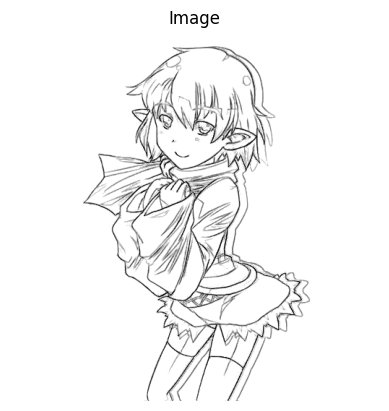

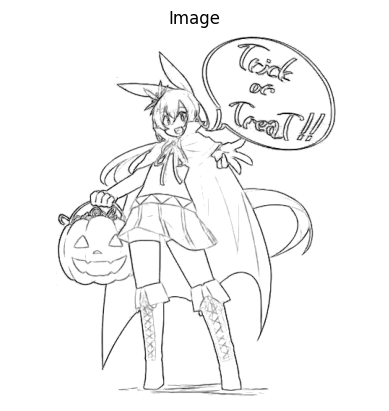

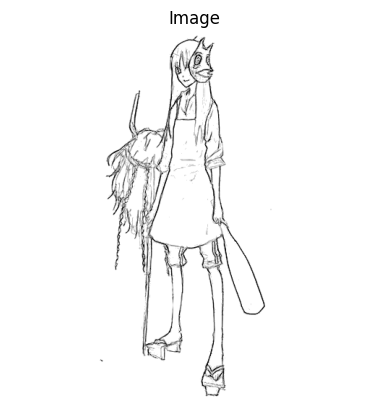

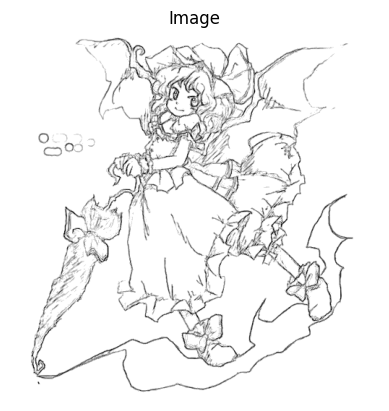

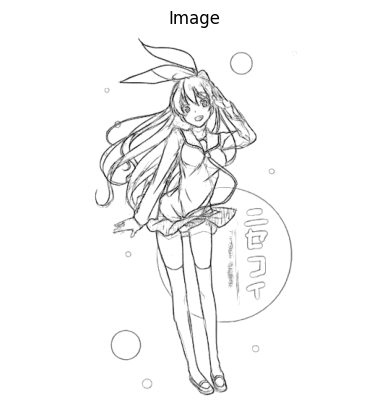

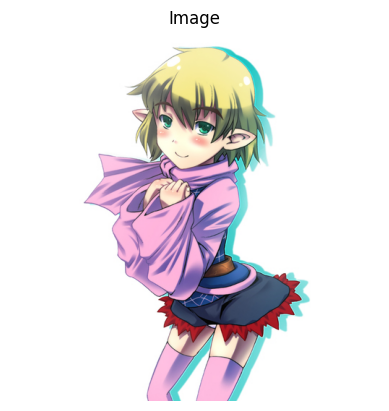

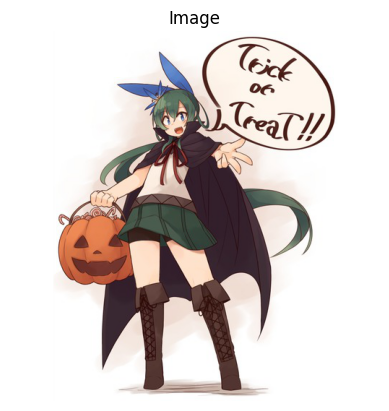

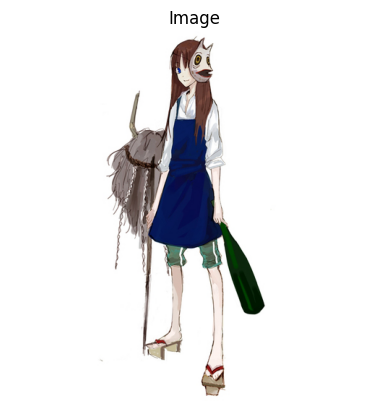

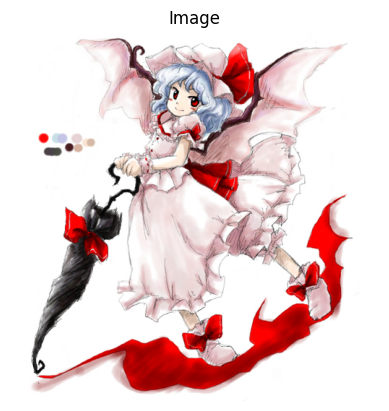

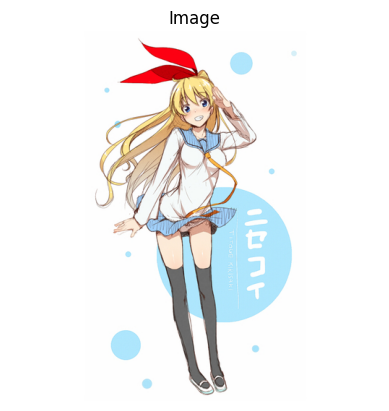

In [5]:
in_l, ou_l = fix_data(main_train_dir)
show_data(in_l)
show_data(ou_l)

In [6]:
def gen_img_plot(img, mask, predictions):
    predictions = np.squeeze(predictions.permute(0, 2, 3, 1).detach().cpu().numpy())
    img = img.permute(0, 2, 3, 1).cpu().numpy()
    mask = mask.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(10, 10))
    display_list = [img[0], mask[0], predictions[0]]
    title = ['Input', 'Truth', 'Output']
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)  # Scale image values
        plt.axis('off')
    plt.show()

In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PairedImageDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        # Call the fix_data method using self
        self.input_images, self.target_images = self.fix_data()

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image = self.input_images[idx]
        target_image = self.target_images[idx]

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

    def fix_data(self, percentage=0.1):
        input_list = []
        output_list = []
        main_dir_list = os.listdir(self.main_dir)
        total_files = int(len(main_dir_list) * percentage)

        for i in main_dir_list[:total_files]:
            main_path = os.path.join(self.main_dir, i)
            main_image = Image.open(main_path).convert("RGB")  # Corrected the variable name
            main_image_width, main_image_height = main_image.size

            # Split the image into input and target
            input_image = main_image.crop((0, 0, main_image_width // 2, main_image_height))
            output_image = main_image.crop((main_image_width // 2, 0, main_image_width, main_image_height))

            input_list.append(input_image)
            output_list.append(output_image)

        return input_list, output_list

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images if needed
    transforms.ToTensor()            # Convert images to tensor
])

main_train_dir = "/kaggle/input/anime-sketch-colorization-pair/data/train"
main_val_dir = "/kaggle/input/anime-sketch-colorization-pair/data/val"

train_dataset = PairedImageDataset(main_train_dir, transform=transform)
train_dl = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_dataset = PairedImageDataset(main_val_dir, transform=transform)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False)

 

# Example of iterating through the DataLoader
for inputs, targets in train_dl:
    print("Input batch shape:", inputs.shape)
    print("Target batch shape:", targets.shape)
    break


Input batch shape: torch.Size([16, 3, 256, 256])
Target batch shape: torch.Size([16, 3, 256, 256])


In [8]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(  
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True), 
        )
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x, is_bn=True):
        x = self.conv_relu(x)  
        if is_bn:  
            x = self.bn(x)
        return x

In [9]:
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.LeakyReLU(inplace=True),
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x, is_drop=False):  # Properly aligned
        x = self.upconv_relu(x)
        x = self.bn(x)
        if is_drop:
            x = F.dropout2d(x)
        return x


In [10]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm


class Generator(nn.Module):  
    def __init__(self):
        super(Generator, self).__init__()
        
        self.down1 = Downsample(3, 64)  
        self.down2 = Downsample(64, 128)  
        self.down3 = Downsample(128, 256) 
        self.down4 = Downsample(256, 512)  
        self.down5 = Downsample(512, 512)  
        self.down6 = Downsample(512, 512) 

       
        self.up1 = Upsample(512, 512)
        self.up2 = Upsample(1024, 512) 
        self.up3 = Upsample(1024, 256)  
        self.up4 = Upsample(512, 128)  
        self.up5 = Upsample(256, 64)  

        self.last = nn.ConvTranspose2d(128, 3,
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1)
        
    def forward(self, x):  
        
        x1 = self.down1(x)  
        x2 = self.down2(x1)  
        x3 = self.down3(x2) 
        x4 = self.down4(x3)  
        x5 = self.down5(x4) 
        x6 = self.down6(x5)  
       
      
        x6 = self.up1(x6, is_drop=True) 
        x6 = torch.cat([x6, x5], dim=1)  

        x6 = self.up2(x6, is_drop=True)  
        x6 = torch.cat([x6, x4], dim=1)  

        x6 = self.up3(x6, is_drop=True) 
        x6 = torch.cat([x6, x3], dim=1)

        x6 = self.up4(x6) 
        x6 = torch.cat([x6, x2], dim=1)

        x6 = self.up5(x6)  
        x6 = torch.cat([x6, x1], dim=1)  
       
        x = torch.tanh(self.last(x6))  
        return x
   
     

In [11]:
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
      
        self.down1 = Downsample(6, 64) 
        self.down2 = Downsample(64, 128)  
        self.cov1 = nn.Conv2d(128, 256, kernel_size=3)  
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256, 1, kernel_size=3)  

    def forward(self, img, mask):  
        x = torch.cat([img, mask], dim=1)  
        x = self.down1(x, is_bn=False)  
        x = self.down2(x)
        x = F.dropout2d(self.bn(F.leaky_relu(self.cov1(x)))) 
        x = torch.sigmoid(self.last(x)) 
        return x

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
netD = Discriminator().to(device)
netG = Generator().to(device)
OptimizerD = torch.optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.999))
OptimizerG = torch.optim.Adam(netG.parameters(), lr=1e-3, betas=(0.5, 0.999))
BCE_Loss = nn.BCELoss()
L1_Loss = nn.L1Loss()
D_loss_list=[]
G_loss_list=[]
D_acc_list=[]


Epoch: 0, D_loss: 1.3934, G_loss: 0.8451, D_acc: 0.4979


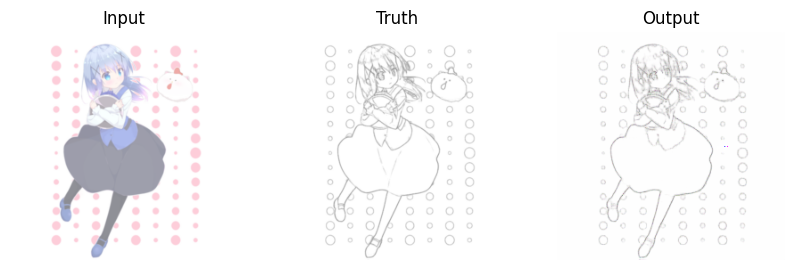

Epoch: 1, D_loss: 1.3909, G_loss: 0.8386, D_acc: 0.5094


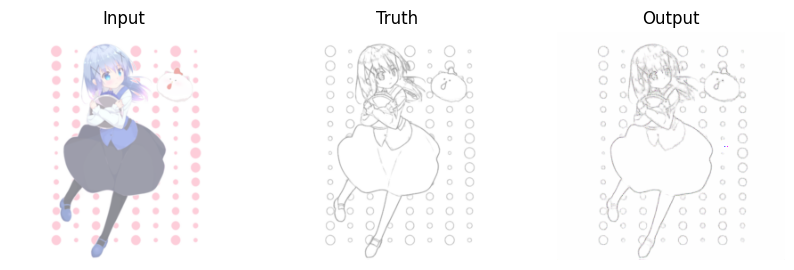

Epoch: 2, D_loss: 1.3887, G_loss: 0.8322, D_acc: 0.5177


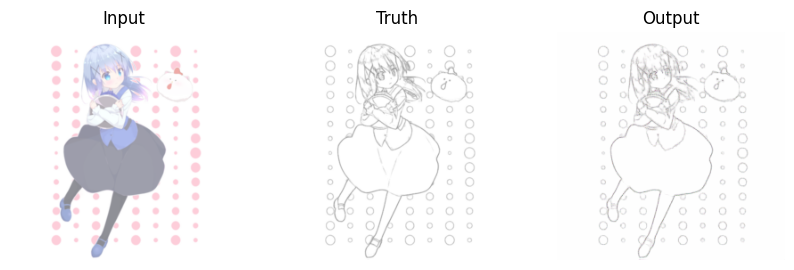

Epoch: 3, D_loss: 1.3925, G_loss: 0.8261, D_acc: 0.5022


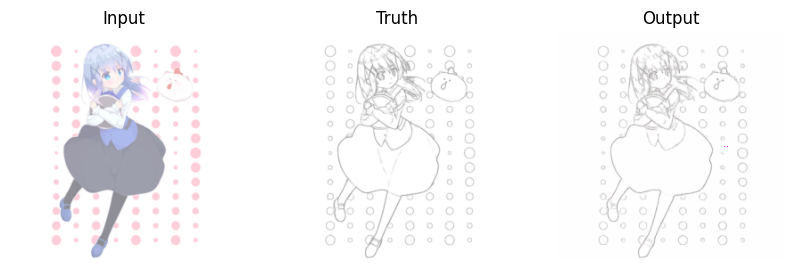

Epoch: 4, D_loss: 1.3922, G_loss: 0.8233, D_acc: 0.4992


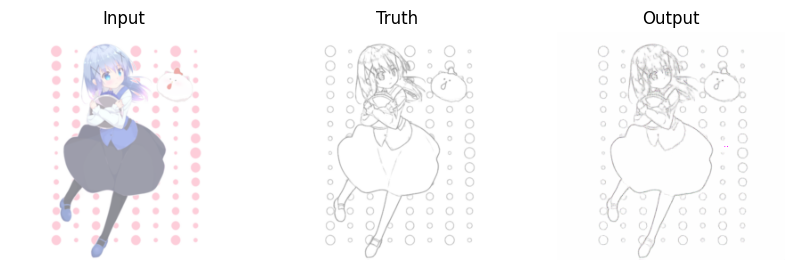

Epoch: 5, D_loss: 1.3914, G_loss: 0.8159, D_acc: 0.4997


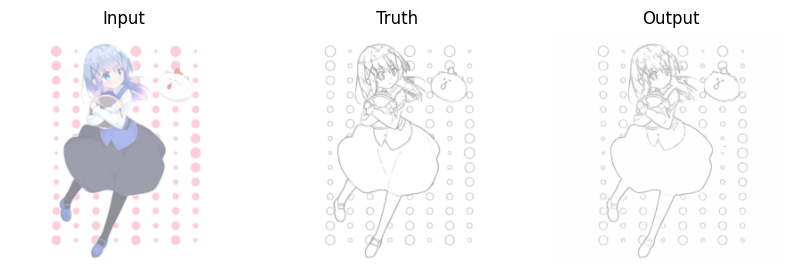

Epoch: 6, D_loss: 1.3893, G_loss: 0.8100, D_acc: 0.5019


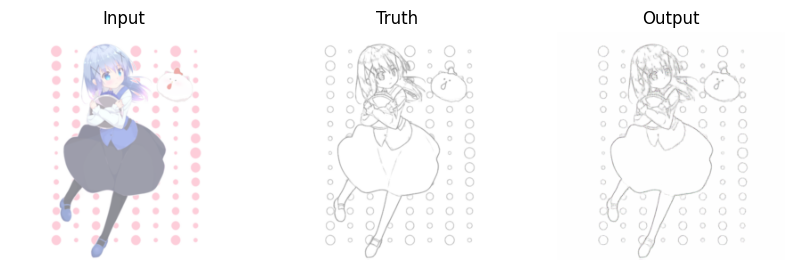

Epoch: 7, D_loss: 1.3918, G_loss: 0.8086, D_acc: 0.4947


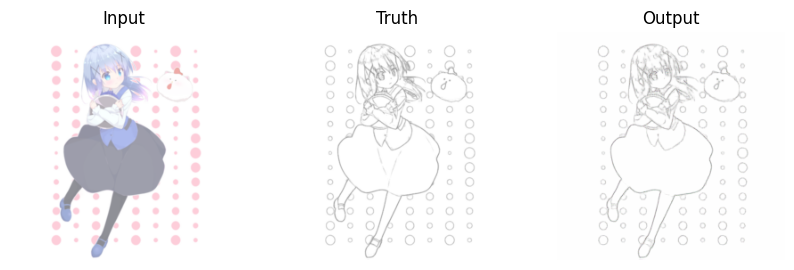

Epoch: 8, D_loss: 1.3886, G_loss: 0.8080, D_acc: 0.5063


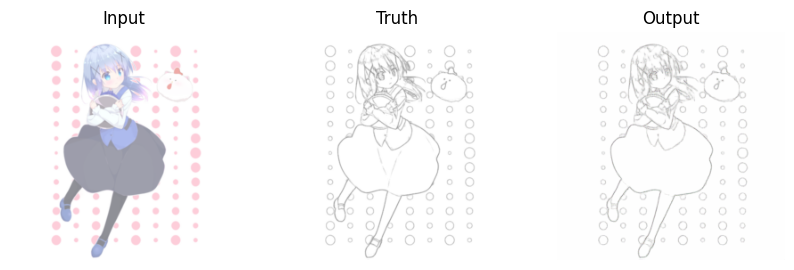

Epoch: 9, D_loss: 1.3879, G_loss: 0.8053, D_acc: 0.5097


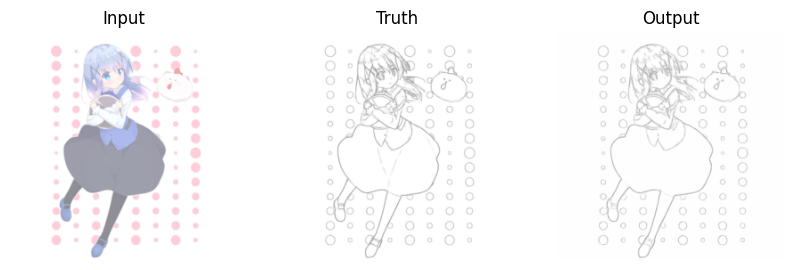

Epoch: 10, D_loss: 1.3902, G_loss: 0.8010, D_acc: 0.5079


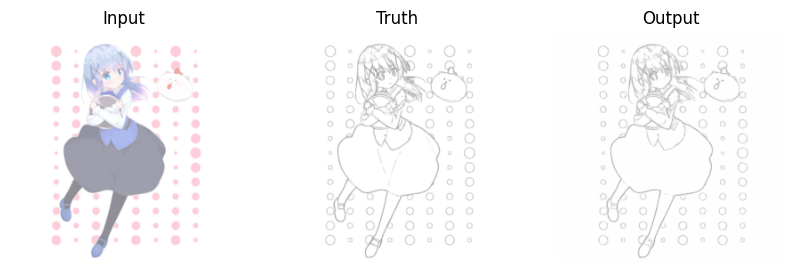

Epoch: 11, D_loss: 1.3898, G_loss: 0.8005, D_acc: 0.5121


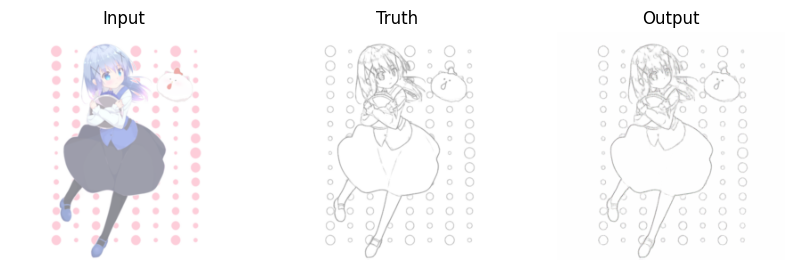

Epoch: 12, D_loss: 1.3883, G_loss: 0.7961, D_acc: 0.5083


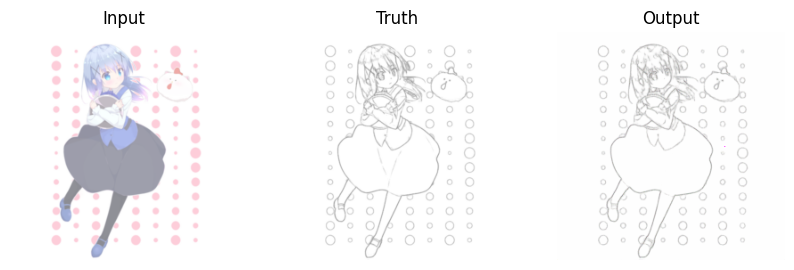

Epoch: 13, D_loss: 1.3922, G_loss: 0.7931, D_acc: 0.4904


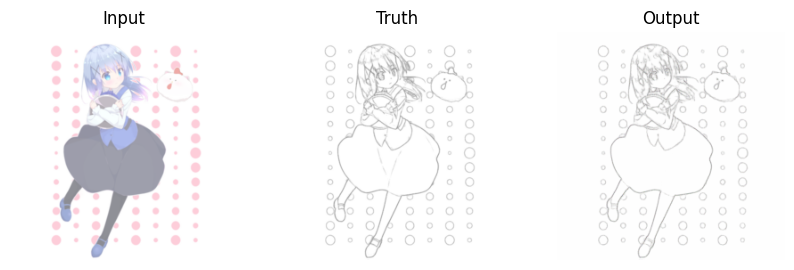

Epoch: 14, D_loss: 1.3892, G_loss: 0.7938, D_acc: 0.5057


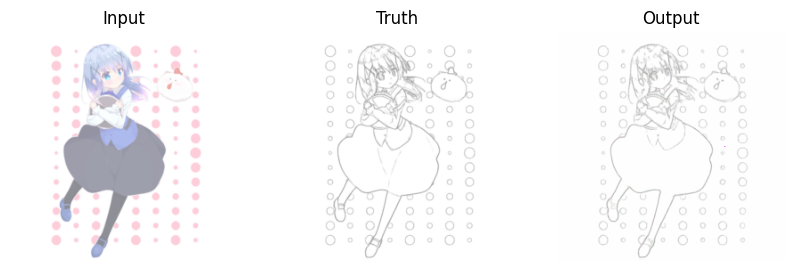

Epoch: 15, D_loss: 1.3882, G_loss: 0.7917, D_acc: 0.5056


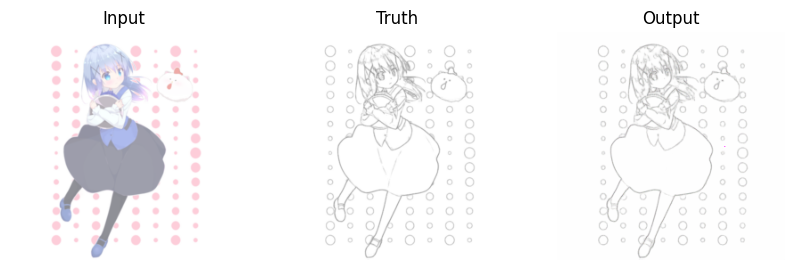

Epoch: 16, D_loss: 1.3897, G_loss: 0.7913, D_acc: 0.5073


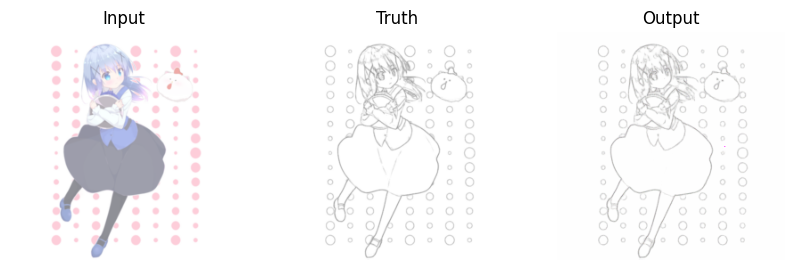

Epoch: 17, D_loss: 1.3886, G_loss: 0.7882, D_acc: 0.4969


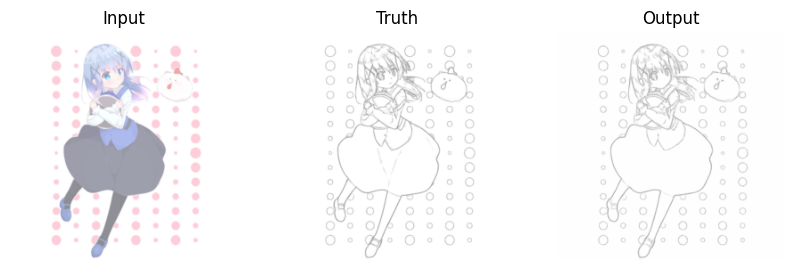

Epoch: 18, D_loss: 1.3900, G_loss: 0.7886, D_acc: 0.5000


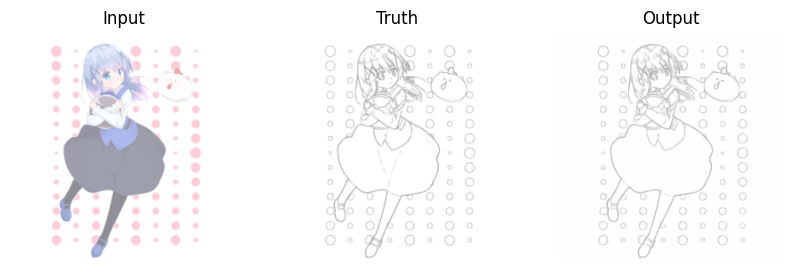

Epoch: 19, D_loss: 1.3902, G_loss: 0.7845, D_acc: 0.4925


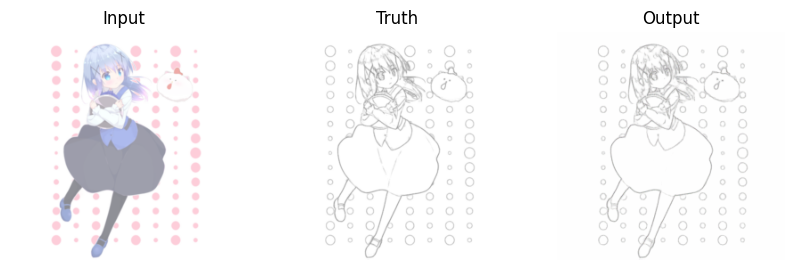

In [19]:
best_gan_loss = float('inf')  # Initialize best loss to positive infinity
best_gan_model = None

for epoch in range(20):
    D_epoch_loss = 0
    G_epoch_loss = 0
    D_epoch_acc = 0
    count = len(train_dl)
    for step, (imgs, masks) in enumerate(train_dl):
        imgs = imgs.to(device)
        masks = masks.to(device)
        OptimizerD.zero_grad()
        D_real = netD(imgs, masks)
        D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real))
        D_real_loss.backward()
        G_img = netG(imgs)

        D_fake = netD(imgs, G_img.detach())
        D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake))
        D_fake_loss.backward()
        D_loss = D_real_loss + D_fake_loss
        OptimizerD.step()

        G_loss = 0
        for _ in range(3):
            OptimizerG.zero_grad()
            G_img = netG(imgs)

            D_fake = netD(imgs, G_img)

            G_loss_BEC = BCE_Loss(D_fake, torch.ones_like(D_fake))
            G_loss_L1 = L1_Loss(G_img, masks)


            G_loss = G_loss_BEC + 7 * G_loss_L1
            G_loss.backward()
            OptimizerG.step()

        with torch.no_grad():
            D_epoch_loss += D_loss.item()
            G_epoch_loss += G_loss.item()

            D_real_acc = (D_real >= 0.5).float().mean().item()
            D_fake_acc = (D_fake < 0.5).float().mean().item()
            D_epoch_acc += (D_real_acc + D_fake_acc) / 2


    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_epoch_acc /= count
        D_loss_list.append(D_epoch_loss)
        G_loss_list.append(G_epoch_loss)
        D_acc_list.append(D_epoch_acc)
        print(f'Epoch: {epoch}, D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}, D_acc: {D_epoch_acc:.4f}')
        gen_img_plot(imgs, masks, G_img)
        
        current_gan_loss = D_epoch_loss + G_epoch_loss 
        
        if current_gan_loss < best_gan_loss:  
            best_gan_loss = current_gan_loss
            best_gan_model = {  
                'netG': netG.state_dict(),
                'netD': netD.state_dict()
            }


    

In [20]:
if best_gan_model is not None:
    print("Saving best model with combined loss:", best_gan_loss)
    # Use torch.save to save the best_gan_model dictionary to a file
    torch.save(best_gan_model, 'best_gan_model.pt')

Saving best model with combined loss: 2.17466621586446


In [21]:
checkpoint = torch.load('best_gan_model.pt') 

<ipython-input-21-e2b897730354>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_gan_model.pt')


In [22]:

netG.load_state_dict(checkpoint['netG'])
netD.load_state_dict(checkpoint['netD'])


<All keys matched successfully>

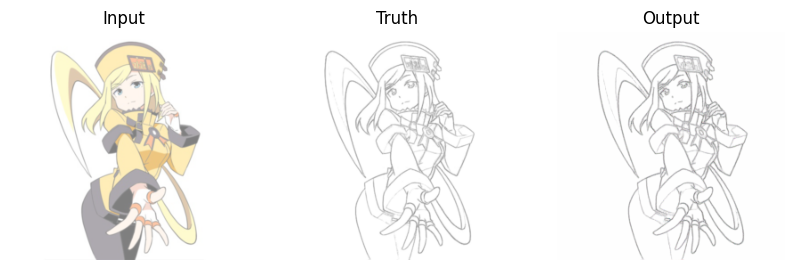

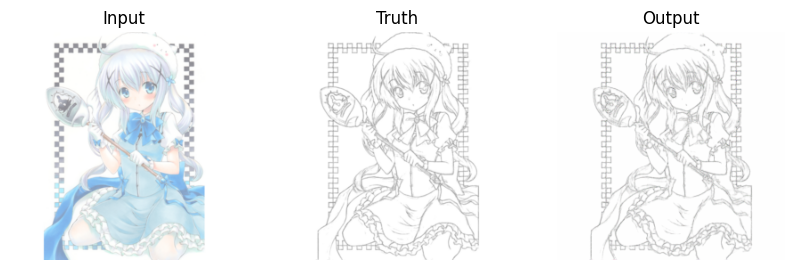

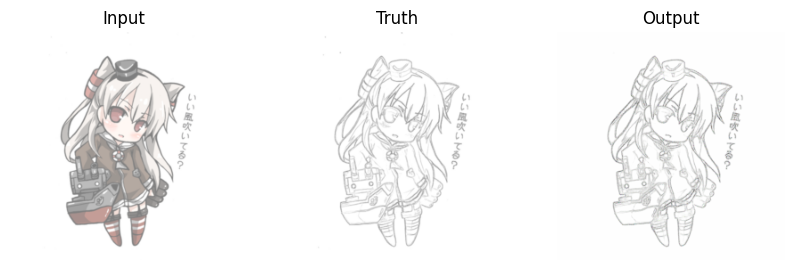

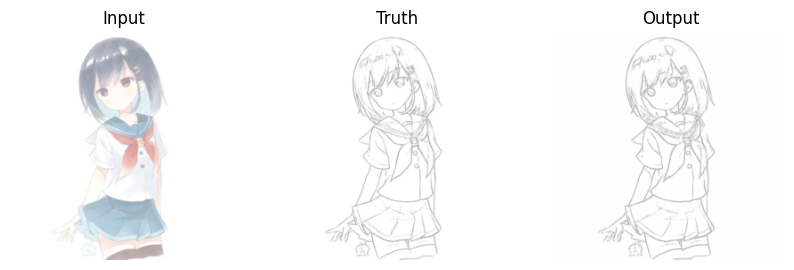

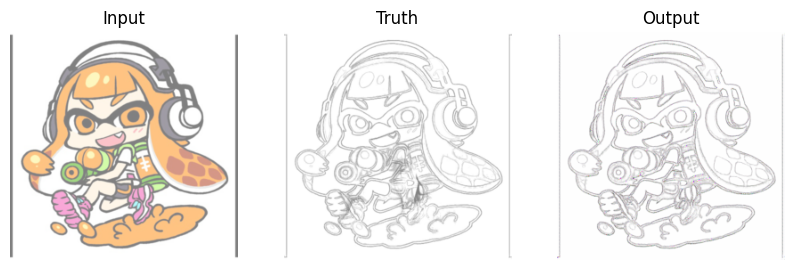

In [271]:
import random

j = 0
for inputs, targets in val_dl:
    # Move data to device (if using GPU)
    inn = inputs.to(device)
    t = targets.to(device)

    # Generate images
    im = netG(inn).to(device)

    # Randomly select 10 images (with some optimizations)
    num_images_to_show = min(10, len(inputs))  # Ensure we don't exceed dataloader size
    random_indices = random.sample(range(len(inputs)), num_images_to_show)
    selected_inputs = inn[random_indices]
    selected_targets = t[random_indices]
    selected_generated_images = im[random_indices]

    # Visualize images
    gen_img_plot(selected_inputs, selected_targets, selected_generated_images)

    j += 1
    if j >= 5:
        break